1. calculate rolling 45d std
2. calulcate implied volatility
3. cacluate VaR of the nex 45d
4. calculate the VaR using std and implied volatility
5. compare them

In [1]:
from src.data import Option
option = Option(
    tag="SHASTA_CALL",
    stock_symbol="شستا",
    option_symbol="ضستا6006",
    strike=1065,
    maturity_date="1402-06-08",
    call=True
)

In [2]:
from src.data import fetch_data
df = fetch_data(option=option)

In [3]:
from src.data import add_std, add_T, add_rf
df = add_std(df, rolling_window=90)
df.rename(columns={"std": "rolling_std"}, inplace=True)
df = add_T(option=option, data=df)
df = add_rf(data=df)

In [4]:
df['stock_returns'] = df['S0'].pct_change()

In [6]:
# add 45 days rolling Value at risk
df['rolling_VaR'] = df['stock_returns'].rolling(90).quantile(0.05)

In [7]:
from src.options import Volatility

import pandas as pd
import numpy as np
def calc_implied_vol(row):
    if any(pd.isnull(row)):
        return np.nan
    return Volatility.implied_volatility(row['S0'], option.strike, row['T'], row['rf'], row['actual_option'], row['rolling_std'])

In [8]:
df['implied_vol'] = df.apply(calc_implied_vol, axis=1)

/Users/ali/Documents/advanced_stochastic/project/src/options.py:384: RuntimeWarning: divide by zero encountered in scalar divide
  sigma_est -= (
/Users/ali/Documents/advanced_stochastic/project/src/options.py:352: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / \
/Users/ali/Documents/advanced_stochastic/project/src/options.py:354: RuntimeWarning: invalid value encountered in scalar divide
  d2 = (math.log(S / K) + (r - 0.5 * sigma ** 2) * T) / \
/Users/ali/Documents/advanced_stochastic/project/src/options.py:363: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / \


In [9]:
df

,date,S0,actual_option,rolling_std,T,rf,stock_returns,rolling_VaR,implied_vol
0,2022-04-10,1029.0,NaN,NaN,1.389041,NaN,NaN,NaN,NaN
1,2022-04-11,1017.0,NaN,NaN,1.386301,NaN,-0.011662,NaN,NaN
2,2022-04-12,975.0,NaN,NaN,1.383562,NaN,-0.041298,NaN,NaN
3,2022-04-13,983.0,NaN,NaN,1.380822,NaN,0.008205,NaN,NaN
4,2022-04-16,985.0,NaN,NaN,1.372603,NaN,0.002035,NaN,NaN
...,...,...,...,...,...,...,...,...,...
280,2023-07-01,1274.0,274.0,0.344096,0.164384,0.2622,-0.007788,-0.033737,0.539575
281,2023-07-02,1286.0,295.0,0.344029,0.161644,0.2622,0.009419,-0.033737,0.641743
282,2023-07-03,1306.0,295.0,0.342731,0.158904,0.2622,0.015552,-0.033737,0.481984
283,2023-07-04,1316.0,320.0,0.342697,0.156164,0.2622,0.007657,-0.033737,0.656965


<Axes: >

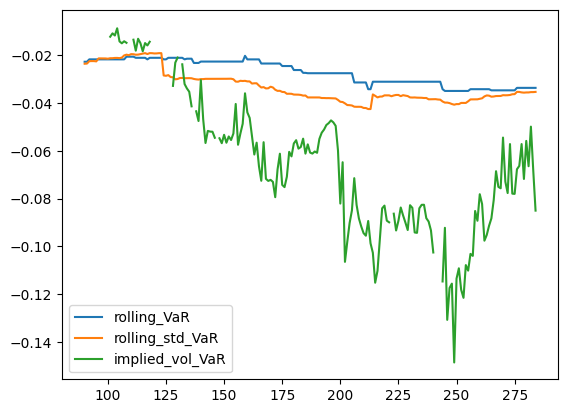

In [34]:
# Assuming df is your DataFrame
from scipy.stats import norm
# Computing VaR at 95% confidence level using rolling_std
Z_95 = norm.ppf(1-0.05)
df['rolling_std_VaR'] = - Z_95 * df['rolling_std'] * np.sqrt(1/252)

# Computing VaR at 95% confidence level using implied_vol
df['implied_vol_VaR'] = - Z_95 * df['implied_vol'] * np.sqrt(1/252)

# Now you have three VaR columns: rolling_VaR, rolling_std_VaR, and implied_vol_VaR.
# All are in the same units, so they can be directly compared.
# Let's plot them over time:
df[['rolling_VaR', 'rolling_std_VaR', 'implied_vol_VaR']].plot()